# SpotNMatch Evaluation Notebook
This Notebook evaluates SpotNMatch by investigating the correlation between scores returned and two deconvolution methods: pre-trained AntiSplodge models and our greedy integral selector.

In [7]:
import anndata as ann
import scanpy as sc
import matplotlib.pyplot as plot
import multiprocessing
import numpy as np
import pandas as pd
import pickle
import torch

import antisplodge as AS

from collections import Counter

from scstmatch.deconvolution import IntegralDeconvolver, GreedySelector
from scstmatch.deconvolution.evaluation import evaluate_jsd, evaluate_rmse
from scstmatch.data import SingleCellDataset, SpatialTranscriptomicsDataset
from scstmatch.matching import SpotNMatch

In [8]:
class Signature:
    def __init__(self, sig: tuple[list[str], list[str]]):
        self.genes = sig[0]
        self.cell_types = sig[1]


class Reference:
    def __init__(self, dataset: SingleCellDataset, signature: Signature, model: AS.CelltypeDeconvolver):
        self.dataset = dataset
        self.signature = signature
        self.model = model

## Import
We import the signatures and the models to properly match deconvolution performance on different datasets.

In [9]:
DATA_PATH = "../../../data"
REFERENCE_PATH = f"{DATA_PATH}/reference"
REFERENCE_DATASETS = {
    ("Harvard", "full", "F"): f"{REFERENCE_PATH}/hca_harvard_gender_Female.sc.h5ad",
    ("Harvard", "V1", "F"): f"{REFERENCE_PATH}/hca_harvard_gender_Female_-muscles.sc.h5ad",
    ("Harvard", "V2", "F"): f"{REFERENCE_PATH}/hca_harvard_gender_Female_-endothelial.sc.h5ad",
    ("Sanger", "full", "F"): f"{REFERENCE_PATH}/hca_sanger_gender_Female.sc.h5ad",
    ("Sanger", "V1", "F"): f"{REFERENCE_PATH}/hca_sanger_gender_Female_-muscles.sc.h5ad",
    ("Sanger", "V2", "F"): f"{REFERENCE_PATH}/hca_sanger_gender_Female_-endothelial.sc.h5ad",
}

references = {}

for name, path in REFERENCE_DATASETS.items():
    with open(f"{name[0]}_gender_female_{name[1]}.signature.pickle", "rb") as f:
        signature = Signature(pickle.load(f))
    dataset = SingleCellDataset.read(path)
    experiment = AS.DeconvolutionExperiment(dataset.anndata[:, signature.genes])
    experiment.setCellTypeColumn(dataset.cell_type_column)
    experiment.num_features = len(signature.genes)
    experiment.setupModel(cuda_id=0)
    model = experiment.model
    model.load_state_dict(torch.load(f"{name[0]}_gender_female_{name[1]}.model.pt", map_location=model.Get("device")))
    references[name] = Reference(dataset, signature, model)

We import the target datasets with known profiles.

In [10]:
TARGET_PATH = f"{DATA_PATH}/st"
TARGET_DATASETS = {
    ("Harvard", "full", "H6"): f"{TARGET_PATH}/hca_harvard_donor_H6.st.h5ad",
    ("Harvard", "V1", "H6"): f"{TARGET_PATH}/hca_harvard_donor_H6_-muscles.st.h5ad",
    ("Harvard", "V2", "H6"): f"{TARGET_PATH}/hca_harvard_donor_H6_-endothelial.st.h5ad",
    ("Sanger", "full", "D5"): f"{TARGET_PATH}/hca_sanger_donor_D5.st.h5ad",
    ("Sanger", "V1", "D5"): f"{TARGET_PATH}/hca_sanger_donor_D5_-muscles.st.h5ad",
    ("Sanger", "V2", "D5"): f"{TARGET_PATH}/hca_sanger_donor_D5_-endothelial.st.h5ad",
    ("Harvard", "full", "H7"): f"{TARGET_PATH}/hca_harvard_donor_H7.st.h5ad",
    ("Harvard", "V1", "H7"): f"{TARGET_PATH}/hca_harvard_donor_H7_-muscles.st.h5ad",
    ("Harvard", "V2", "H7"): f"{TARGET_PATH}/hca_harvard_donor_H7_-endothelial.st.h5ad",
    ("Sanger", "full", "D1"): f"{TARGET_PATH}/hca_sanger_donor_D1.st.h5ad",
    ("Sanger", "V1", "D1"): f"{TARGET_PATH}/hca_sanger_donor_D1_-muscles.st.h5ad",
    ("Sanger", "V2", "D1"): f"{TARGET_PATH}/hca_sanger_donor_D1_-endothelial.st.h5ad",
}

targets = {}

for name, path in TARGET_DATASETS.items():
    targets[name] = SpatialTranscriptomicsDataset.read(path)

## Processing

### AntiSplodge Deconvolution
We apply the AntiSplodge models to the target datasets and evaluate its accuracy.

In [23]:
as_predictions = {}

as_jsd_spots = {}
as_jsd_mean = []
as_rmse_spots = {}
as_rmse_mean = []

for ref, reference in references.items():
    for name, target in targets.items():
        target_data = target.copy_with(target.anndata[:, reference.signature.genes].copy())
        sc.pp.normalize_total(target_data.anndata, target_sum=1)
        X = torch.tensor(target_data.anndata.X.todense(), device=reference.model.Get("device"))
        Y_pred = reference.model.forward(X).detach().clamp(min=0).cpu().numpy()
        Y_pred /= Y_pred.sum(axis=1)[:, np.newaxis]
        key = (ref, name)
        predicted = pd.DataFrame(Y_pred, index=target_data.anndata.obsm["Y"].index, columns=reference.signature.cell_types)
        as_predictions[key] = predicted

        as_jsd_spots[key] = evaluate_jsd(target, predicted)
        as_jsd_mean.append(as_jsd_spots[key].mean())
        as_rmse_spots[key] = evaluate_rmse(target, predicted)
        as_rmse_mean.append(as_rmse_spots[key].mean())

/Users/potti/Documents/HPI/thesis/spatialtranscriptomics/st_data_gen/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:1297: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


### Greedy Integral Deconvolution
We apply our integral deconvolver using the greedy selector and evaluate its accuracy.

In [12]:
# Precomputed 95 gene selection
GENES = ['ABCA6', 'ABCA8', 'ABCA9', 'ACACB', 'ACSL1', 'ACTA2', 'ADGRB3', 'ANK3',
         'ANKRD44', 'ANO2', 'ARHGAP15', 'BCL2', 'BICC1', 'BTNL9', 'CADM2',
         'CADPS', 'CARMIL1', 'CARMN', 'CCND3', 'CD163', 'CDC42SE2', 'CDH19',
         'CMYA5', 'CTNNA3', 'DCN', 'DLC1', 'DOCK2', 'EGFL7', 'EGFLAM', 'EHBP1',
         'ELMO1', 'EPS8', 'ERBB4', 'FHL2', 'FKBP5', 'FMN1', 'FRMD3', 'FRMD4B',
         'FYN', 'GNAQ', 'GPAM', 'GRIP1', 'GUCY1A2', 'ID1', 'IKZF1', 'IQGAP2',
         'KCNAB1', 'LAMA2', 'LDB2', 'LINC02248', 'LIPE-AS1', 'LRMDA', 'MAPK10',
         'MGST1', 'MLIP', 'MYBPC3', 'MYH11', 'MYH6', 'MYL7', 'NEAT1', 'NEGR1',
         'NR2F2-AS1', 'NRXN1', 'NRXN3', 'NTRK3', 'PAM', 'PARP8', 'PDE3B',
         'PDE4DIP', 'PDGFRB', 'PID1', 'PLA2G5', 'PLIN1', 'PNPLA2', 'PRKG1',
         'PTPRB', 'PTPRC', 'RABGAP1L', 'RBM47', 'RGS5', 'RORA', 'RYR2', 'SCN7A',
         'SGCD', 'SKAP1', 'SLC8A1', 'SLIT3', 'SOX5', 'ST6GALNAC3', 'SYNE1',
         'TBXAS1', 'TRDN-AS1', 'TTN', 'VWF', 'ZFHX3']

gd_predictions = {}

gd_jsd_spots = {}
gd_jsd_mean = []
gd_rmse_spots = {}
gd_rmse_mean = []

for reference_key, reference in references.items():
    selector = GreedySelector()
    deconvolver = IntegralDeconvolver(reference.dataset.copy_with(reference.dataset.anndata[:, GENES].copy()), selector=selector)
    for name, target in targets.items():
        target = target.copy_with(target.anndata[:, GENES].copy())
        key = (reference_key, name)
        predicted = deconvolver.deconvolve(target)
        gd_predictions[key] = predicted

        gd_jsd_spots[key] = evaluate_jsd(target, predicted)
        gd_jsd_mean.append(gd_jsd_spots[key].mean())
        gd_rmse_spots[key] = evaluate_rmse(target, predicted)
        gd_rmse_mean.append(gd_rmse_spots[key].mean())

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

### SpotNMatch
We use SpotNMatch to find the matching score values.

In [13]:
scores = {}
mean_score = []

for ref, reference in references.items():
    matcher = SpotNMatch(reference.dataset)
    for name, target in targets.items():
        scores[(ref, name)] = matcher.match(target)[3]
        mean_score.append(scores[(ref, name)].mean())

0.017102s	init train
5.775782s	load
1.326162s	hvg
2.956116s	nnls
0.767291s	hvg
2.900418s	nnls
0.656500s	hvg
2.905277s	nnls
0.667968s	hvg
2.747043s	nnls
0.519800s	hvg
2.690723s	nnls
0.679595s	hvg
2.807419s	nnls
0.718738s	hvg
2.667946s	nnls
0.631542s	hvg
2.950520s	nnls
0.787312s	hvg
2.901282s	nnls
0.539855s	hvg
2.609108s	nnls
0.542929s	hvg
2.675757s	nnls
0.689297s	hvg
2.717948s	nnls
0.008047s	init train
2.203945s	load
1.157274s	nnls
1.156171s	nnls
1.225362s	nnls
1.191300s	nnls
1.387921s	nnls
1.188283s	nnls
1.157768s	nnls
1.207915s	nnls
1.232189s	nnls
1.410900s	nnls
1.154735s	nnls
1.100767s	nnls
0.016975s	init train
5.560538s	load
2.599547s	nnls
2.538894s	nnls
2.747590s	nnls
2.594853s	nnls
2.516929s	nnls
2.519307s	nnls
2.651890s	nnls
2.667724s	nnls
2.666861s	nnls
2.557172s	nnls
2.393540s	nnls
2.546251s	nnls
0.014225s	init train
3.485546s	load
2.618337s	nnls
2.487400s	nnls
2.457959s	nnls
2.496541s	nnls
2.537740s	nnls
2.783454s	nnls
2.608810s	nnls
2.653268s	nnls
2.675299s	nnls
2.923975s	nnl

## Plotting
We plot the results and investigate the correlation.

In [14]:
plot.rcParams.update({
    "text.usetex": True,
})

In [25]:
def plot_mean_correlation(x, y, ylabel, path):
    fig = plot.figure(figsize=(5, 3), dpi=300)
    fig.subplots_adjust(left=0.15, right=0.95, bottom=0.15)
    plt = fig.add_subplot()
    plt.set_xlabel("score")
    plt.set_ylabel(ylabel)

    b, a = np.polyfit(x, y, deg=1)
    Y_pred = np.polyval([b, a], x)
    plt.plot(x, Y_pred, color="grey")

    plt.scatter(x, y)

    print(np.corrcoef(x, y)[0, 1])
    if path:
        fig.savefig(path)

-0.6973112667791889
-0.6767860692473615
-0.5793416209602934
-0.5218251315381119


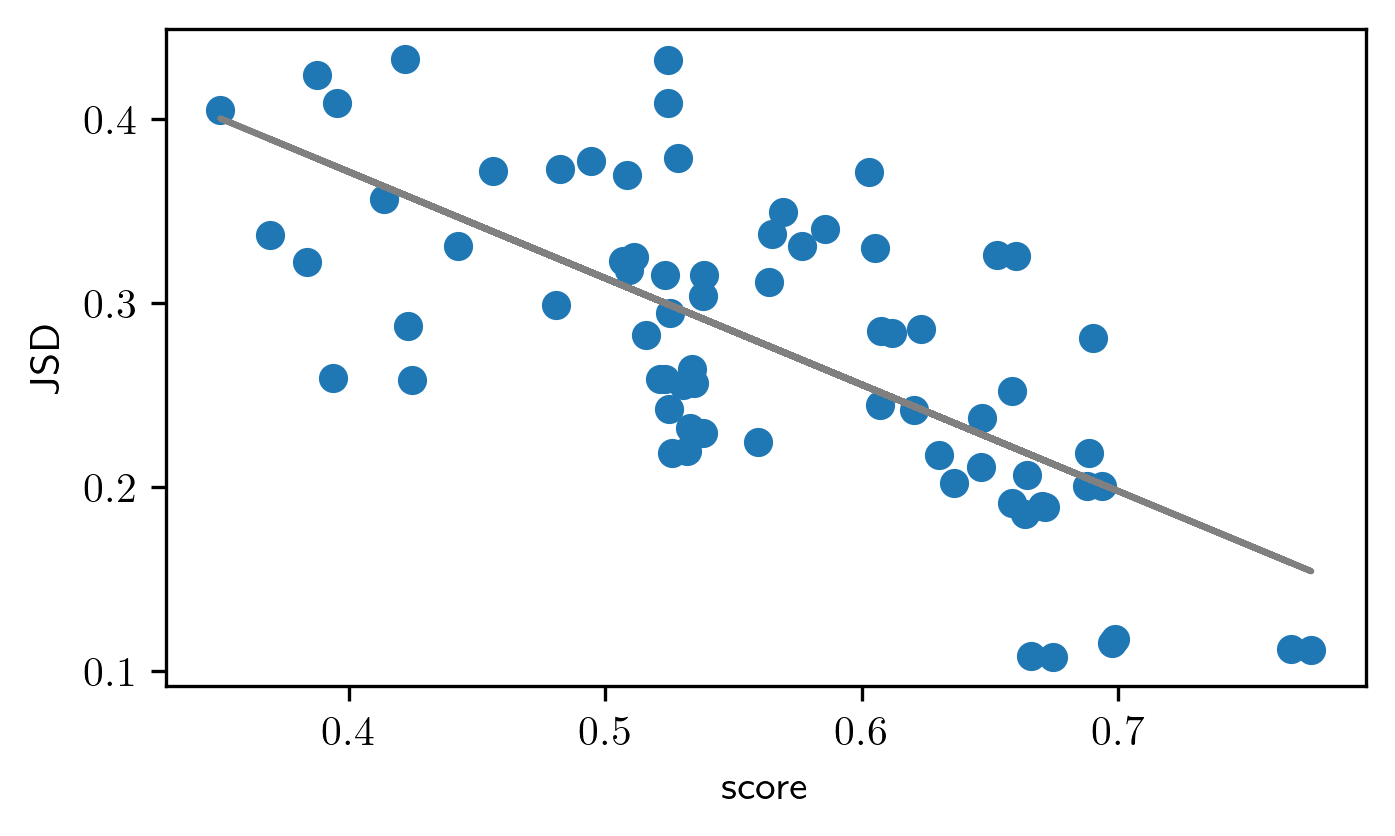

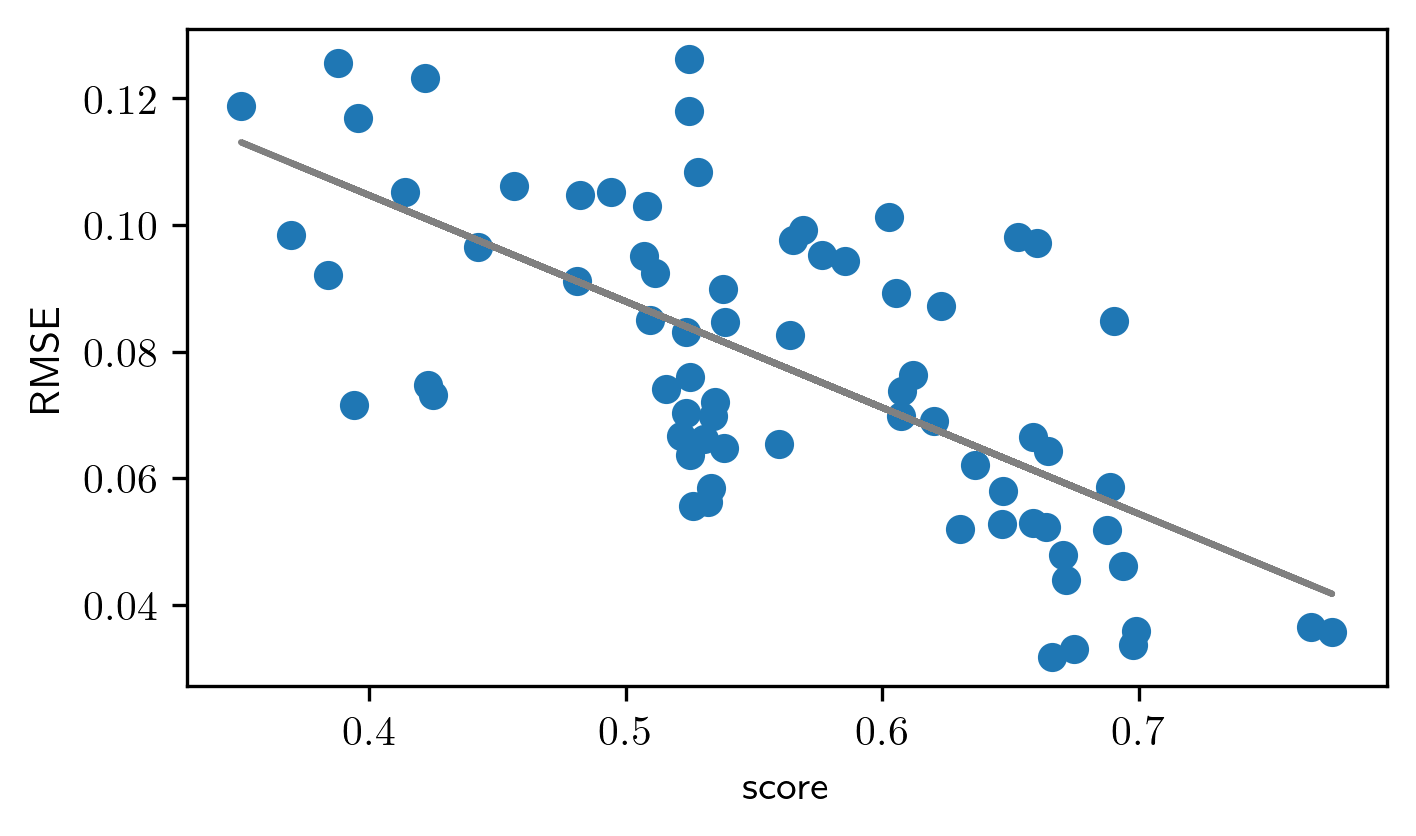

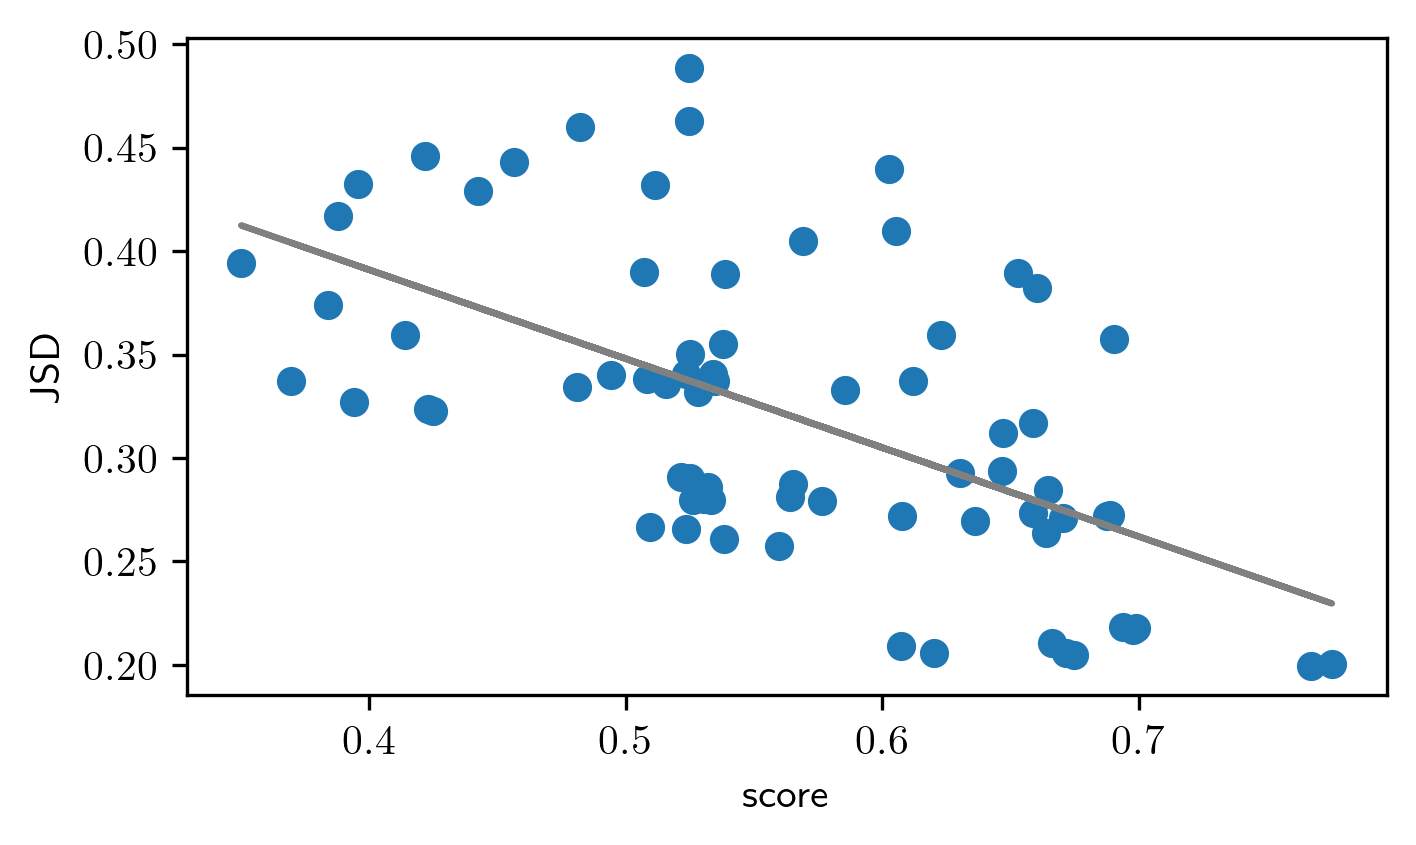

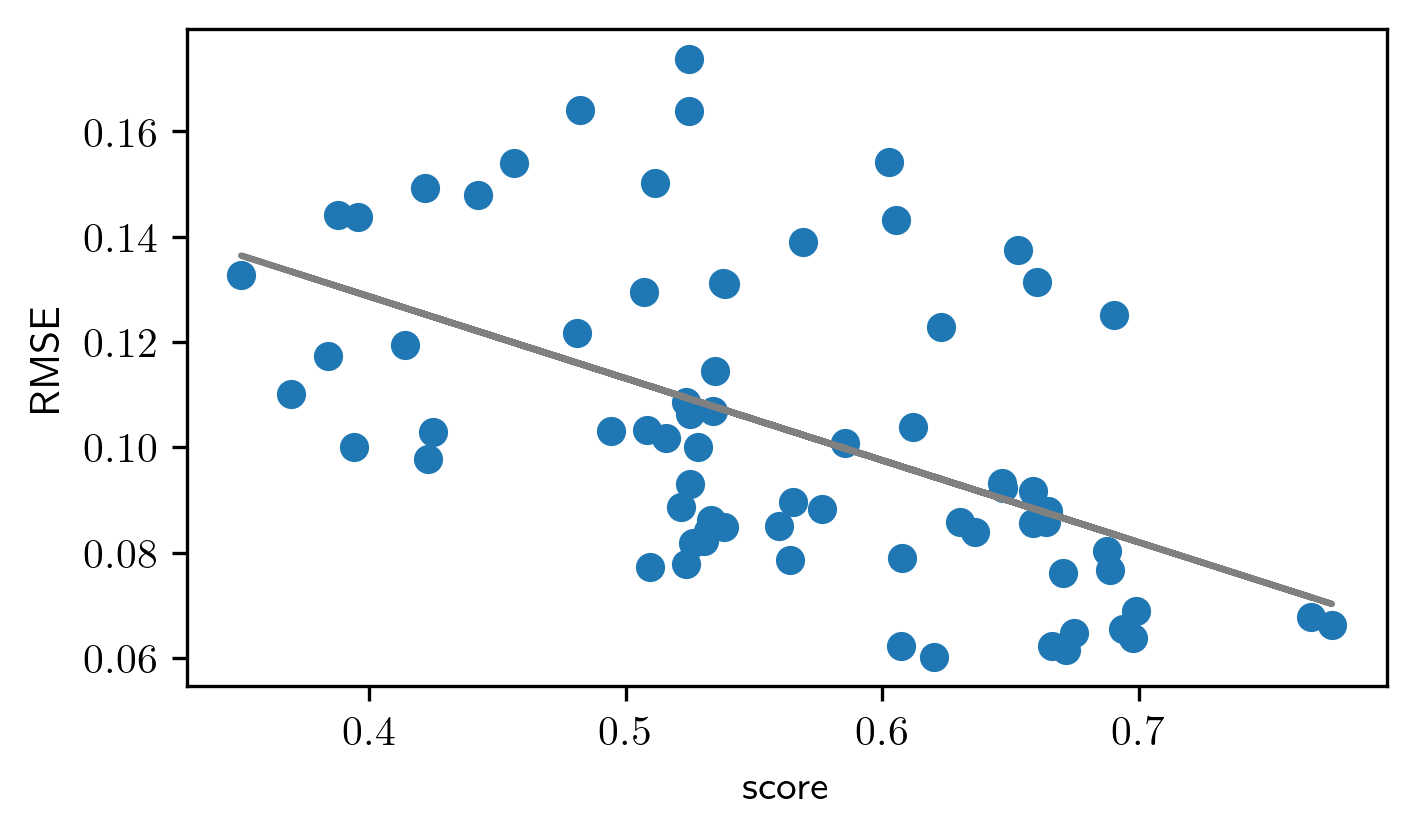

In [26]:
plot_mean_correlation(mean_score, as_jsd_mean, "JSD", "../../output/correlation_antisplodge_jsd.pdf")
plot_mean_correlation(mean_score, as_rmse_mean, "RMSE", "../../output/correlation_antisplodge_rmse.pdf")

plot_mean_correlation(mean_score, gd_jsd_mean, "JSD", "../../output/correlation_greedy_jsd.pdf")
plot_mean_correlation(mean_score, gd_rmse_mean, "RMSE", "../../output/correlation_greedy_rmse.pdf")

In [48]:
reference_keys = list(REFERENCE_DATASETS.keys())[0:2]
reference_labels = list(map(lambda x: f"{x[0]} Female {x[1]}", reference_keys))
n_cols = len(reference_keys)

target_keys = list(TARGET_DATASETS.keys())[0:2]
target_labels = list(map(lambda x: f"{x[0]} Donor {x[2]} {x[1]}", target_keys))
n_rows = len(target_keys)

def plot_spot_excerpt(y, ylabel, path):
    figure, grid = plot.subplots(n_cols, n_rows, figsize=(5,5), dpi=300)
    min_x, min_y = 0.1, 0.1
    max_x, max_y = 0.95, 0.95
    figure.subplots_adjust(min_x, min_y, max_x, max_y)

    for label, index in zip(reference_labels, range(n_rows)):
        grid[index][n_cols - 1].text(1.05, 0.5, label, ha="left", va="center", rotation=-90)
        grid[index][0].set_ylabel(ylabel)

    for label, index in zip(target_labels, range(n_cols)):
        grid[0][index].text(0.5, 1.05, label, va="bottom", ha="center")
        grid[n_cols - 1][index].set_xlabel("score")

    for ref, axes in zip(REFERENCE_DATASETS.keys(), grid):
        for tgt, ax in zip(TARGET_DATASETS.keys(), axes):
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            X = scores[(ref, tgt)]
            Y = y[(ref, tgt)]
            ax.scatter(X, Y, s=1, rasterized=True)

            if np.abs(np.corrcoef(X, Y)[0, 1]) >= 0.5:
                coeffs = np.polyfit(X, Y, deg=1)
                ax.plot(X, np.polyval(coeffs, X), lw=0.5, c="black")

    figure.savefig(path)

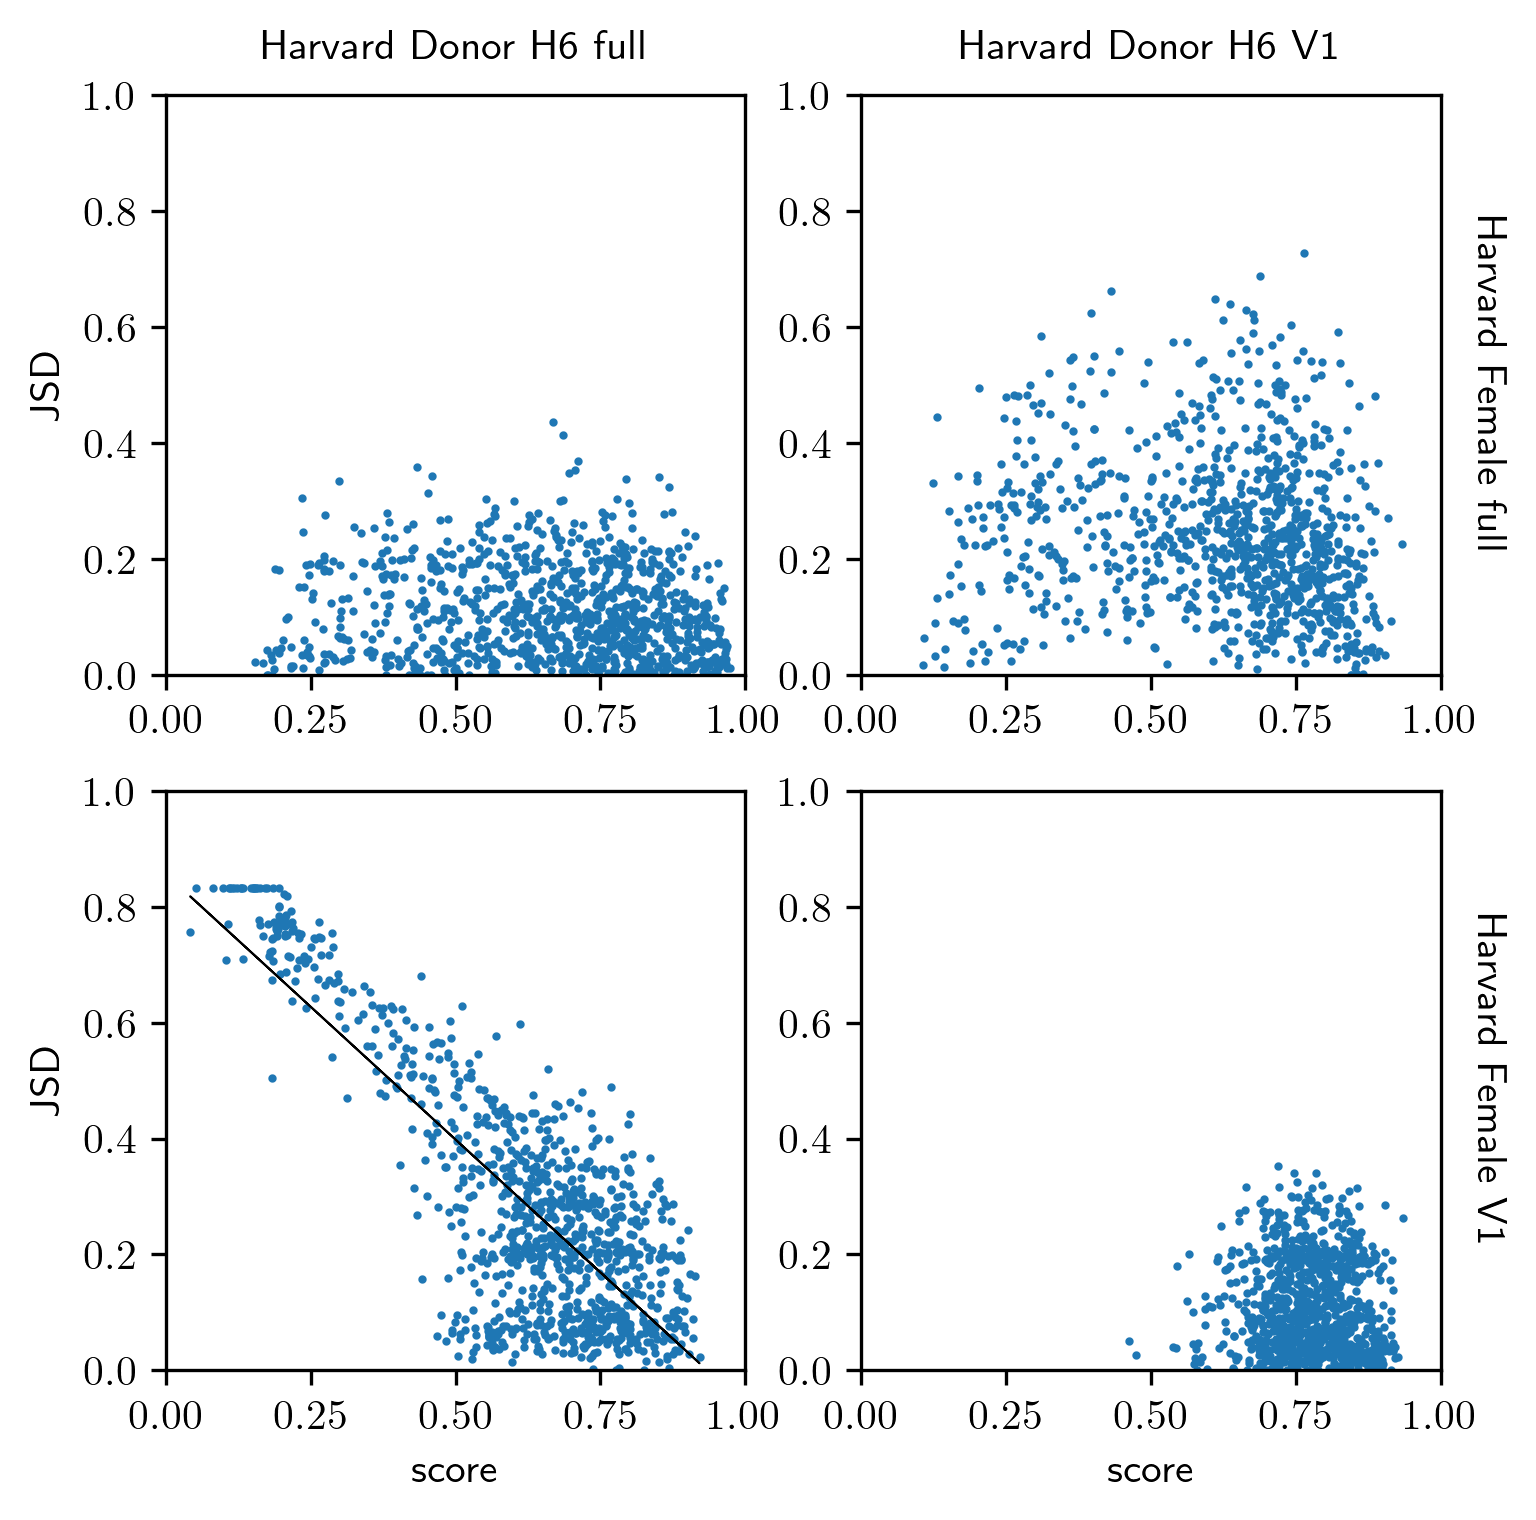

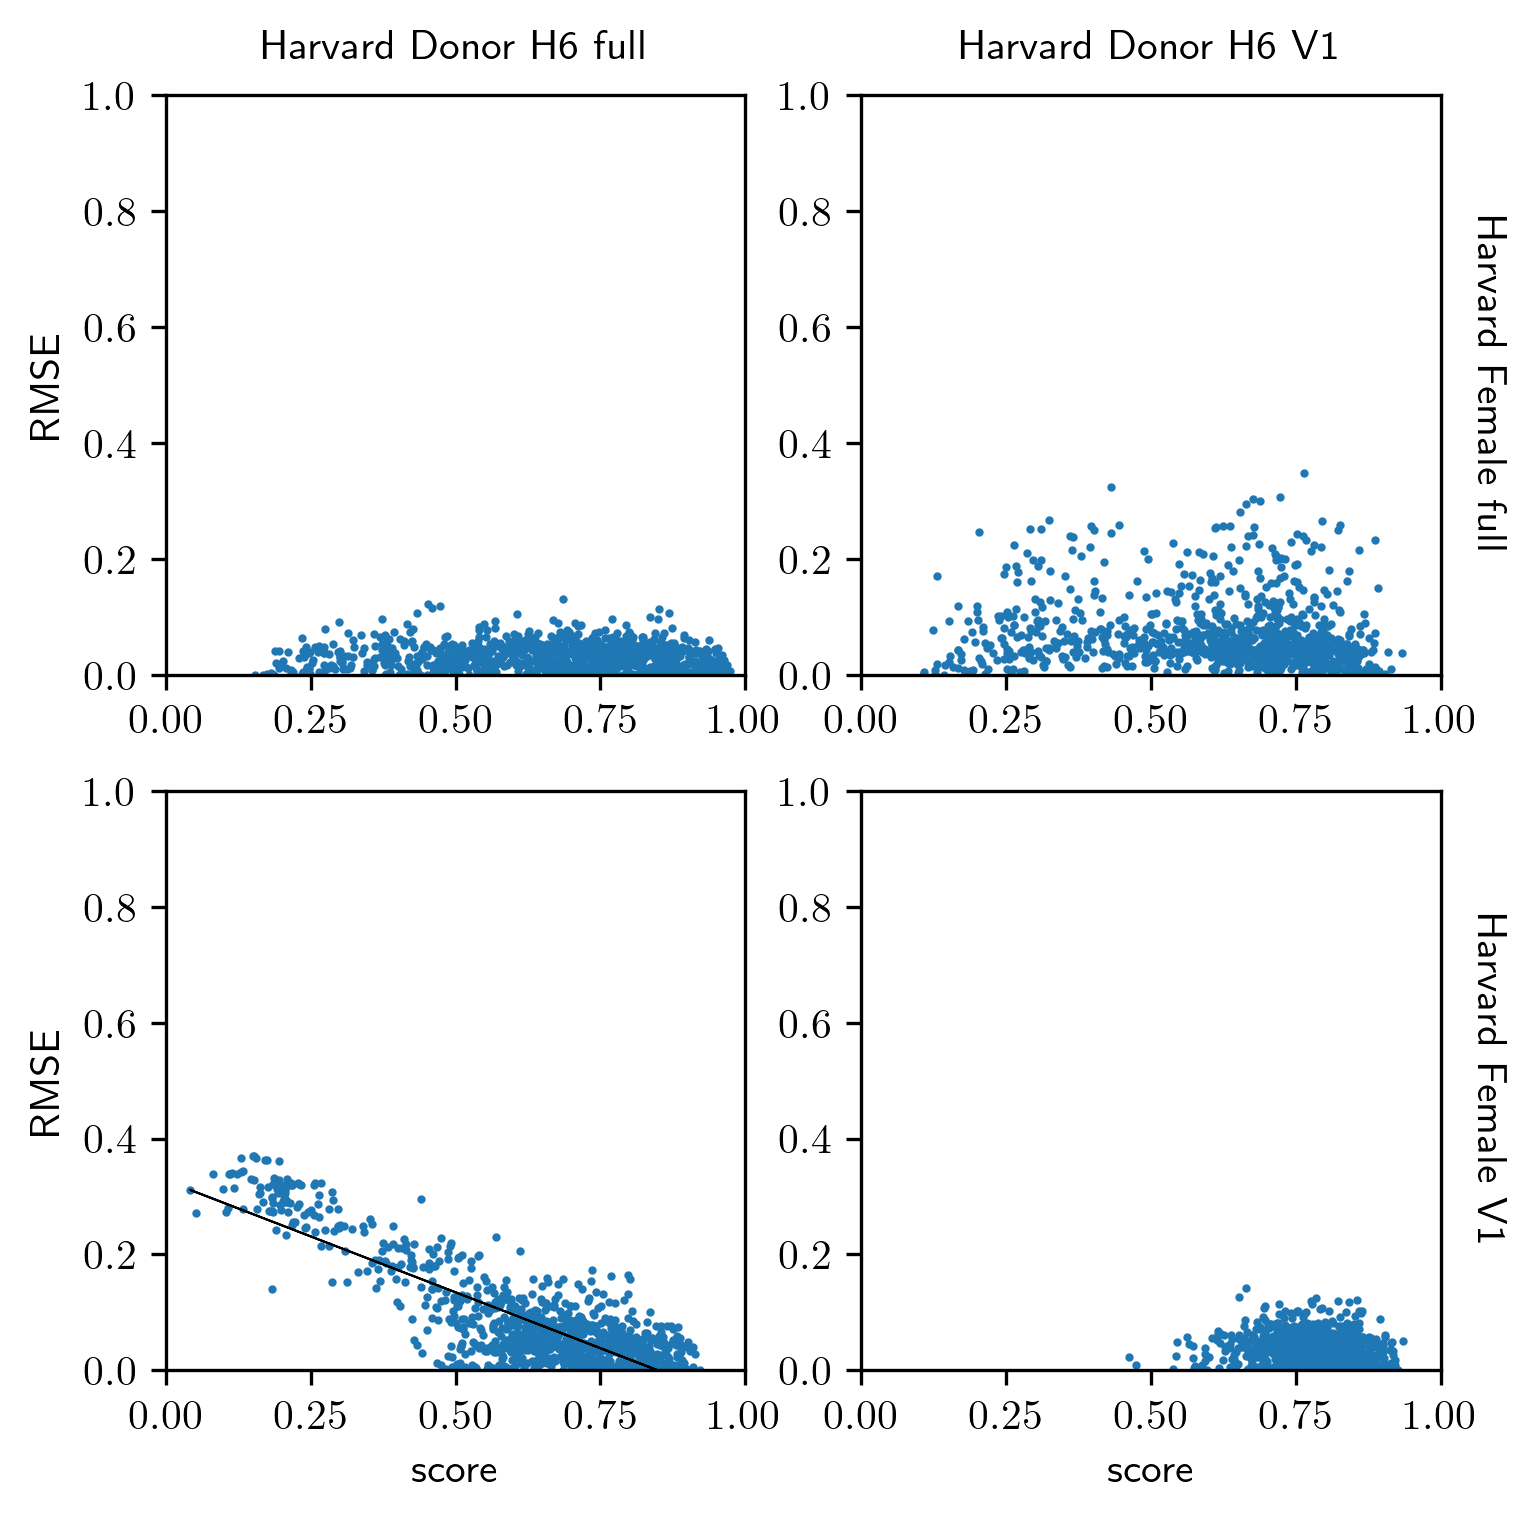

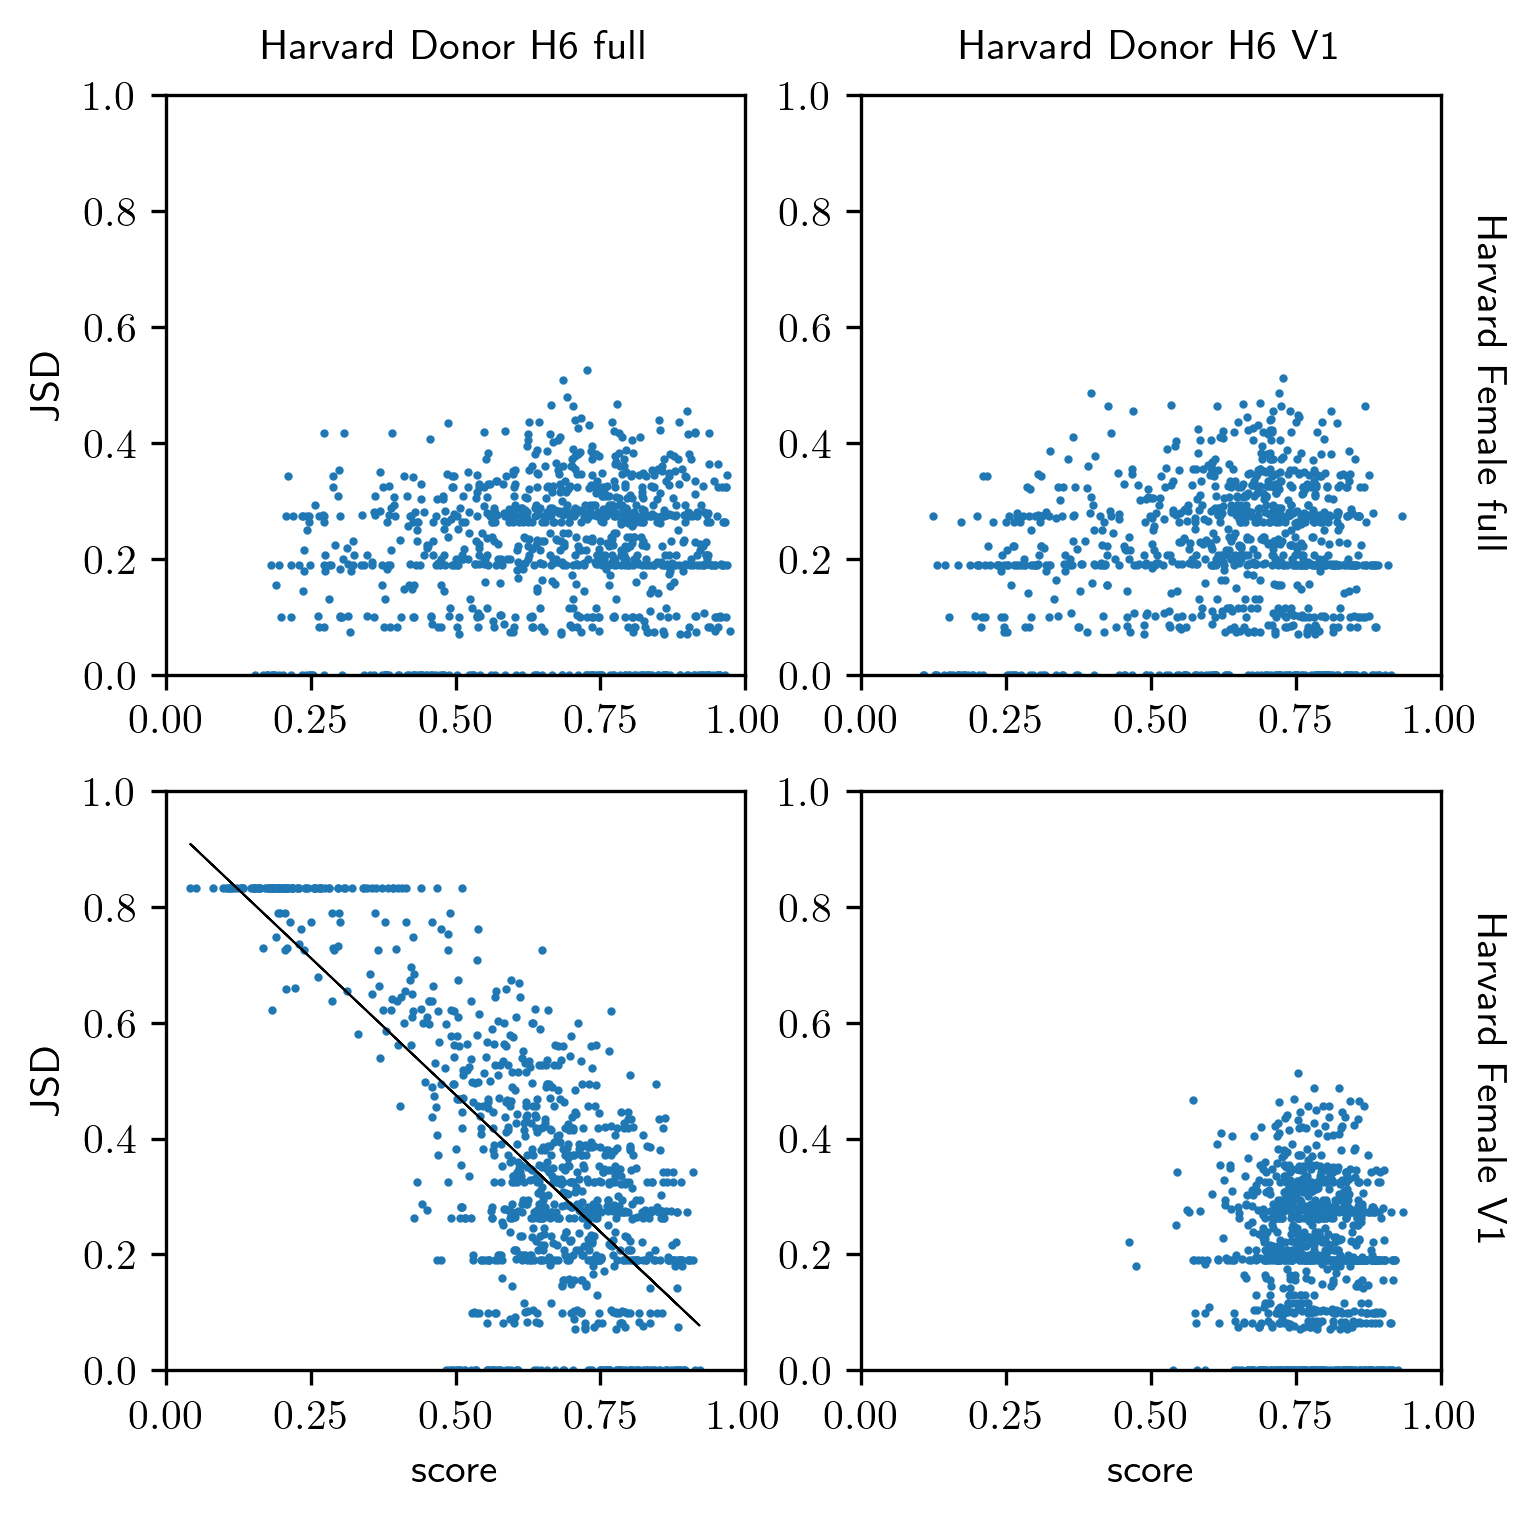

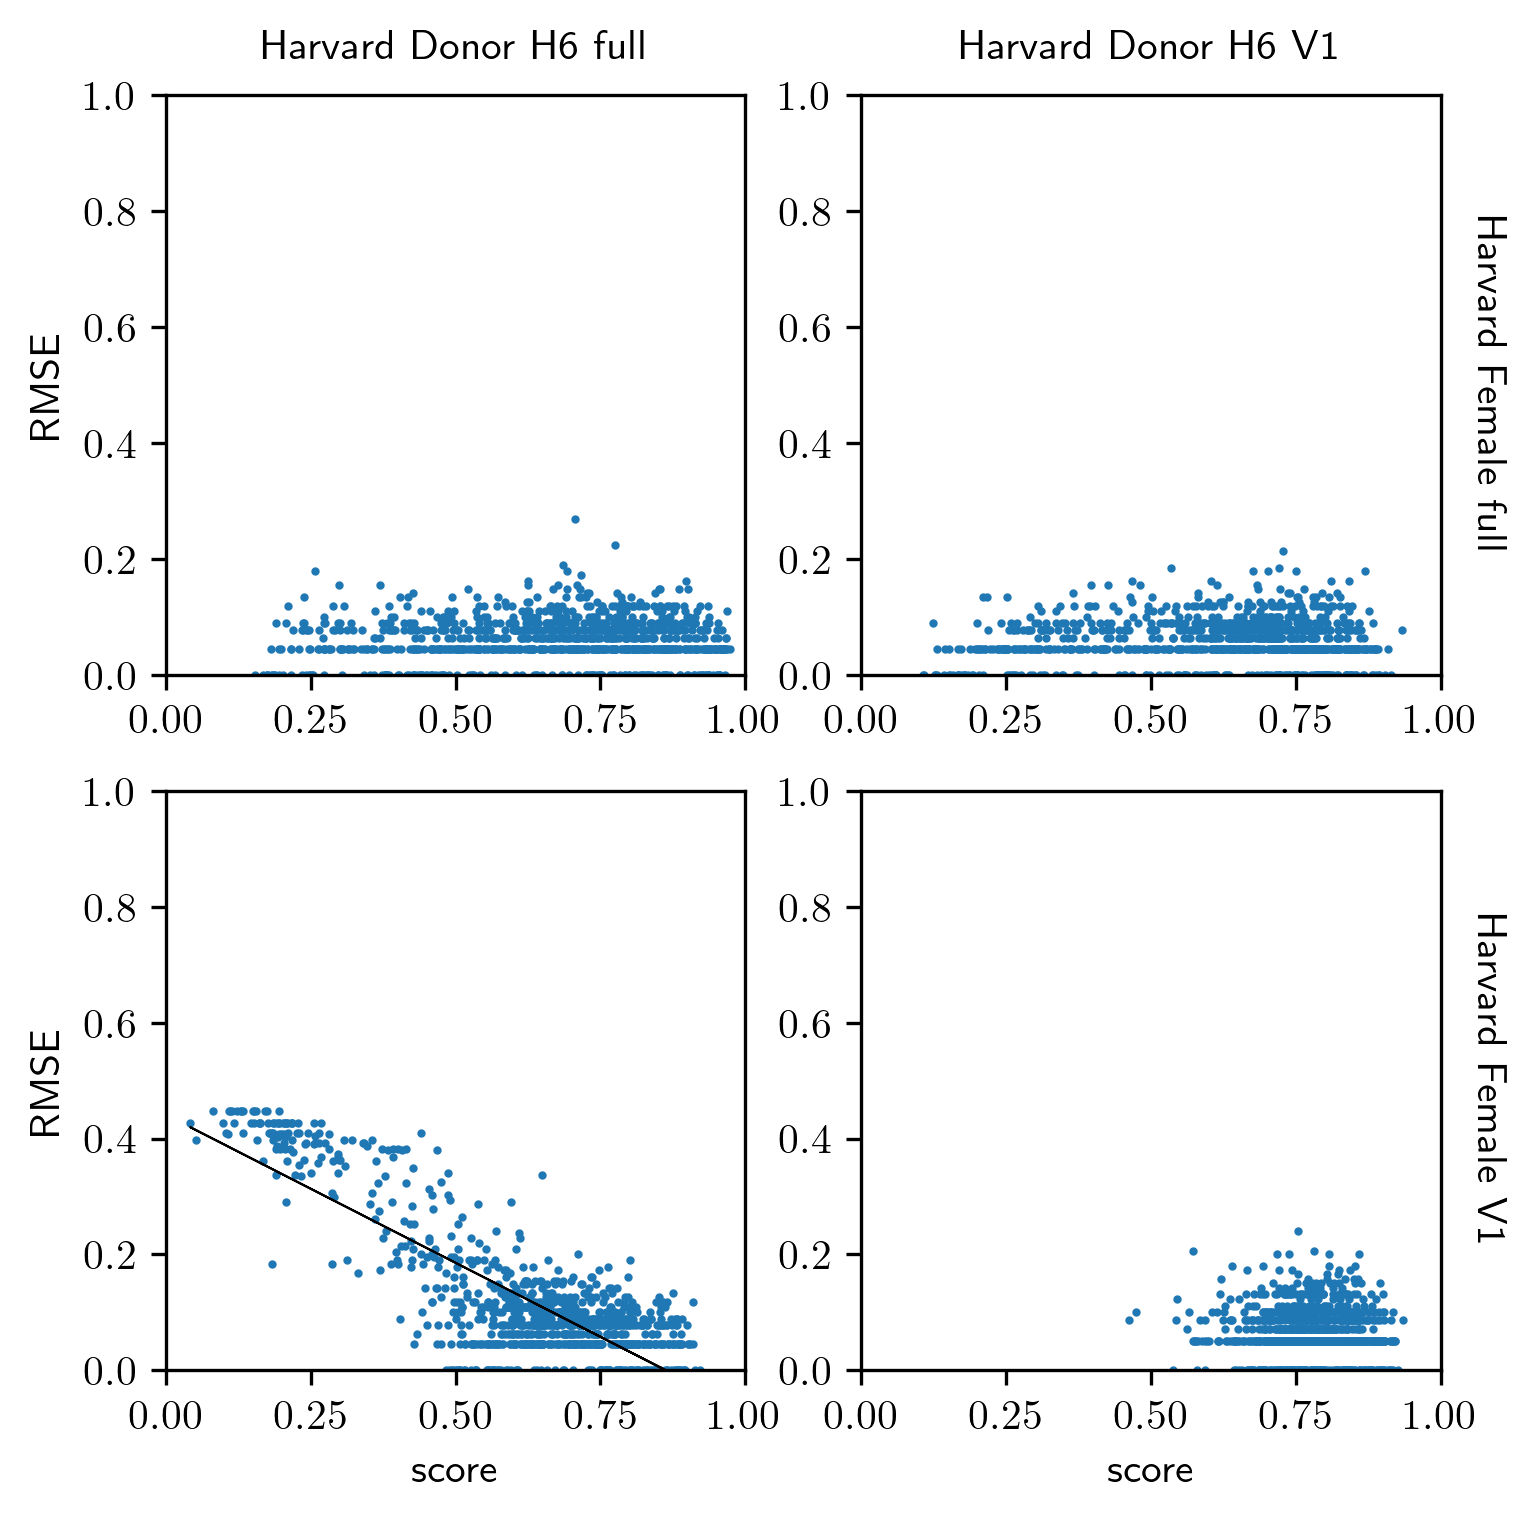

In [49]:
plot_spot_excerpt(as_jsd_spots, "JSD", "../../output/correlation_antisplodge_jsd_grid.pdf")
plot_spot_excerpt(as_rmse_spots, "RMSE", "../../output/correlation_antisplodge_rmse_grid.pdf")

plot_spot_excerpt(gd_jsd_spots, "JSD", "../../output/correlation_greedy_jsd_grid.pdf")
plot_spot_excerpt(gd_rmse_spots, "RMSE", "../../output/correlation_greedy_rmse_grid.pdf")